### [POC 2]  NGLY1 deficiency relation extraction

This analysis builds on POC 1 to process much more data (2 full-text papers w/ ~65k chars total vs ~3.5k chars in POC1) and with much more control over the relations identified. Outline:

1. Define a very detailed [prompt](https://vscode.dev/github/eric-czech/ngly1-gpt/blob/main/ngly1_gpt/resources/prompts/relation_extraction_1.txt) defining entities and relations between them to identify
2. Run this prompt on chunks of each paper
    - There are about 60 chunks total between the two papers
    - This takes ~40 mins w/ GPT4
    - The two papers used are in [data/extract](data/extract)
3. Show examples of text inputs and relation extraction outputs
4. Analyze frequencies of relations and entities

In [1]:
%load_ext autoreload
%autoreload 2
import re
import sys
import json
import pandas as pd
import seaborn as sns
import plotnine as pn
from IPython.display import Markdown
from ngly1_gpt import utils, llm, doc
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option("display.max_colwidth", None, "display.max_rows", 400, "display.max_columns", None)

#### Extraction

For reference, here is the original prompt used that defines the entities and relations for this analysis:

In [29]:
prompt = (utils.get_paths().prompts / "relation_extraction_1.txt").read_text()
print(prompt)

Text will be provided that contains information from a published, biomedical research article about {disease}. Extract subject-predicate-object relations from this text.

Types of subjects and objects to extract:
- assay
- biological process
- cell type
- cellular component
- chemical substance
- clinical trial
- disease
- drug
- gene
- gene family 
- genetic variant
- genotype
- macromolecular complex
- metabolite
- molecular activity
- organism
- organization
- pathway
- phenotype
- protein
- protein variant
- symptom
- tissue
- transcript variant
- <other>

Predicates to extract:
- affects risk for
- associated with
- capable of
- caused by
- causes
- colocalizes with
- contributes to
- correlated with
- decreases abundance of
- decreases activity of
- derives from
- disrupts
- enables
- exact match
- expressed in
- expresses
- genetically interacts with
- has affected feature
- has attribute
- has gene product
- has genotype
- has metabolite
- has output
- has participant
- has phe

##### Execution

This was then used to extract data from the papers using commands like:

```bash
PYTHONPATH="$(pwd)" python ngly1_gpt/cli.py extract_relations --output-filename=relations.tsv 2>&1 | tee data/logs/extract_relations.log.txt
```

The logs for these extractions showing all prompts and results are in [data/logs](data/logs).

#### Examples

Here are a few select examples (from the logs) showing how various input chunks are transformed into structured outputs:

In [120]:
log = "data/logs/extract_relations_1.log.txt"

In [136]:
!echo "Prompt text:"
!cat $log | sed -n "5495,5518p"
!echo "Prompt response:"
!cat $log | sed -n "5541,5567p" | column -s "|" -t

Prompt text:
--- BEGIN TEXT ---
Table 1
Patient #	Age (y) / Sex	Allele #1a	Allele #2a	Functional Scores
Mutation (NM_018297.3)	Protein	Mutation (NM_018297.3)	Protein	Nijmegenb	IQ or DQ	Vinelandc
1	3 / M	c.953T>C	p.L318P	c.1169G>C	p.R390P	 14	ND	62
2	4 / M	c.1201A>T	p.R401*	c.1201A>T	p.R401*	33	25	52
3	4 / F	c.1201A>T	p. R401*	c.1201A>T	p.R401*	34	5	40
4	5 / F	c.931G>A	 p.E311K	c.730T>C	p.W244R	33	ND	ND
5	6 / M	c.1604G>A	p.W535*	 c.1910delT	p.L637*	25	8	43
6	7 / M	c.1891delC	p.Q631S	 c.1201A>T	p.R401*	36	5	37
7	8 / F	c.622C>T	p.Q208*	c.930C>T	p.G310G (splice site)	 10	74	98
8	10 / M	c.622C>T	p. Q208*	c.930C>T	p.G310G (splice site)	 9	81	94
9	16 / M	c.347C>G	p.S116*	c.881+5G>T	IVS5+5G>T	32	2	28
10	17 / F	c.1201A>T	p.R401*	c.1201A>T	p.R401*	25	16	42
11	18 / F	c.1201A>T	p.R401*	c.1201A>T	p.R401*	52	2	24
12	21 / F	c.1370dupG	p.R458Kfs*14	c.1370dupG	p.R458Kfs*14	ND	ND	37
Mean	9	-	-	-	-	28	23	51
SEM	2	-	-	-	-	4	10	7
Abbreviations: IQ, intellectual quotient; DQ, developmental quotient; ND, not

In [135]:
!echo "Prompt text:"
!cat $log | sed -n "6331,6335p"
!echo "Prompt response:"
!cat $log | sed -n "6358,6371p" | column -s "|" -t

Prompt text:
--- BEGIN TEXT ---
CSF Laboratory Results
Nine subjects underwent lumbar puncture. CSF total protein and albumin concentrations, as well as the CSF/serum albumin ratios, were low in nearly all individuals (Supplementary Table S3). There was no correlation between age and CSF protein or albumin levels. In the two oldest subjects, CSF 5-hydroxyindolacetic acid (5-HIAA) and homovanillic acid (HVA) were decreased, suggesting neuronal loss. Neopterin levels were normal but decreased with age, and CSF tetrahydrobiopterin (BH4) levels were below the lower limit of normal in all but one subject tested; however, there was no correlation with age. CSF 5-HIAA, HVA, and BH4 levels strongly and directly correlated with brain atrophy. CSF lactate and amino acid levels were essentially normal (Supplementary Table S3). CSF leucocyte counts (0–4; normal 0–5), glucose concentrations (54–72 mg/dL; normal 40–70), 3-O-methyldopa concentrations (12–28 nM; normal <150) and 5-methyltetrahydrofola

In [134]:
!echo "Prompt text:"
!cat $log | sed -n "8776,8780p"
!echo "Prompt response:"
!cat $log | sed -n "8803,8813p" | column -s "|" -t

Prompt text:
--- BEGIN TEXT ---
Figure 3: Brain MRI findings.
 White matter lesions were seen in two of eleven individuals. A shows multiple lesions in the periventricular white matter, some of which were confluent. B shows a single lesion in the periventricular white matter. Both A and B illustrate cerebral atrophy and were performed using T2-weighting. Sulci are slightly prominent in both A and B, and prominent ventricles are visible in A. C illustrates high position of the cerebellar tonsils, and large foramen of Magendie and cisterna magna.
--- END TEXT ---

Prompt response:
subject               subject_entity      predicate        object                        object_entity
Brain MRI findings    phenotype           has participant  White matter lesions          phenotype
White matter lesions  phenotype           located in       two of eleven individuals     organism
White matter lesions  phenotype           located in       periventricular white matter  cellular component
Cerebr

#### Analysis

In [139]:
relations = pd.read_csv(utils.get_paths().output_data / "relations_2.tsv", sep="\t")
relations.info()
relations.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject         921 non-null    object
 1   subject_entity  921 non-null    object
 2   predicate       921 non-null    object
 3   object          921 non-null    object
 4   object_entity   921 non-null    object
 5   doc_id          921 non-null    object
 6   doc_filename    921 non-null    object
dtypes: object(7)
memory usage: 50.5+ KB


,subject,subject_entity,predicate,object,object_entity,doc_id,doc_filename
0,Mutations,genetic variant,cause,Inherited Disorder of the Endoplasmic Reticulum-Associated Degradation,disease,PMC4243708,PMC4243708.txt
1,NGLY1,gene,has gene product,Mutations,genetic variant,PMC4243708,PMC4243708.txt
2,ERAD pathway,pathway,responsible for,translocation of misfolded proteins,biological process,PMC4243708,PMC4243708.txt
3,ERAD pathway,pathway,has participant,proteasome,molecular activity,PMC4243708,PMC4243708.txt
4,N-glycanase 1,protein,involved in,ERAD pathway,pathway,PMC4243708,PMC4243708.txt
5,NGLY1 deficiency,disease,causes,global developmental delay,phenotype,PMC4243708,PMC4243708.txt
6,NGLY1 deficiency,disease,causes,movement disorder,phenotype,PMC4243708,PMC4243708.txt
7,NGLY1 deficiency,disease,causes,hypotonia,phenotype,PMC4243708,PMC4243708.txt
8,NGLY1 deficiency,disease,associated with,hypo- or alacrima,phenotype,PMC4243708,PMC4243708.txt
9,NGLY1 deficiency,disease,associated with,elevated liver transaminases,phenotype,PMC4243708,PMC4243708.txt


##### Entity/relation frequencies

Show how often entities of various types co-occur:

### Subject/object co-occurrence frequency

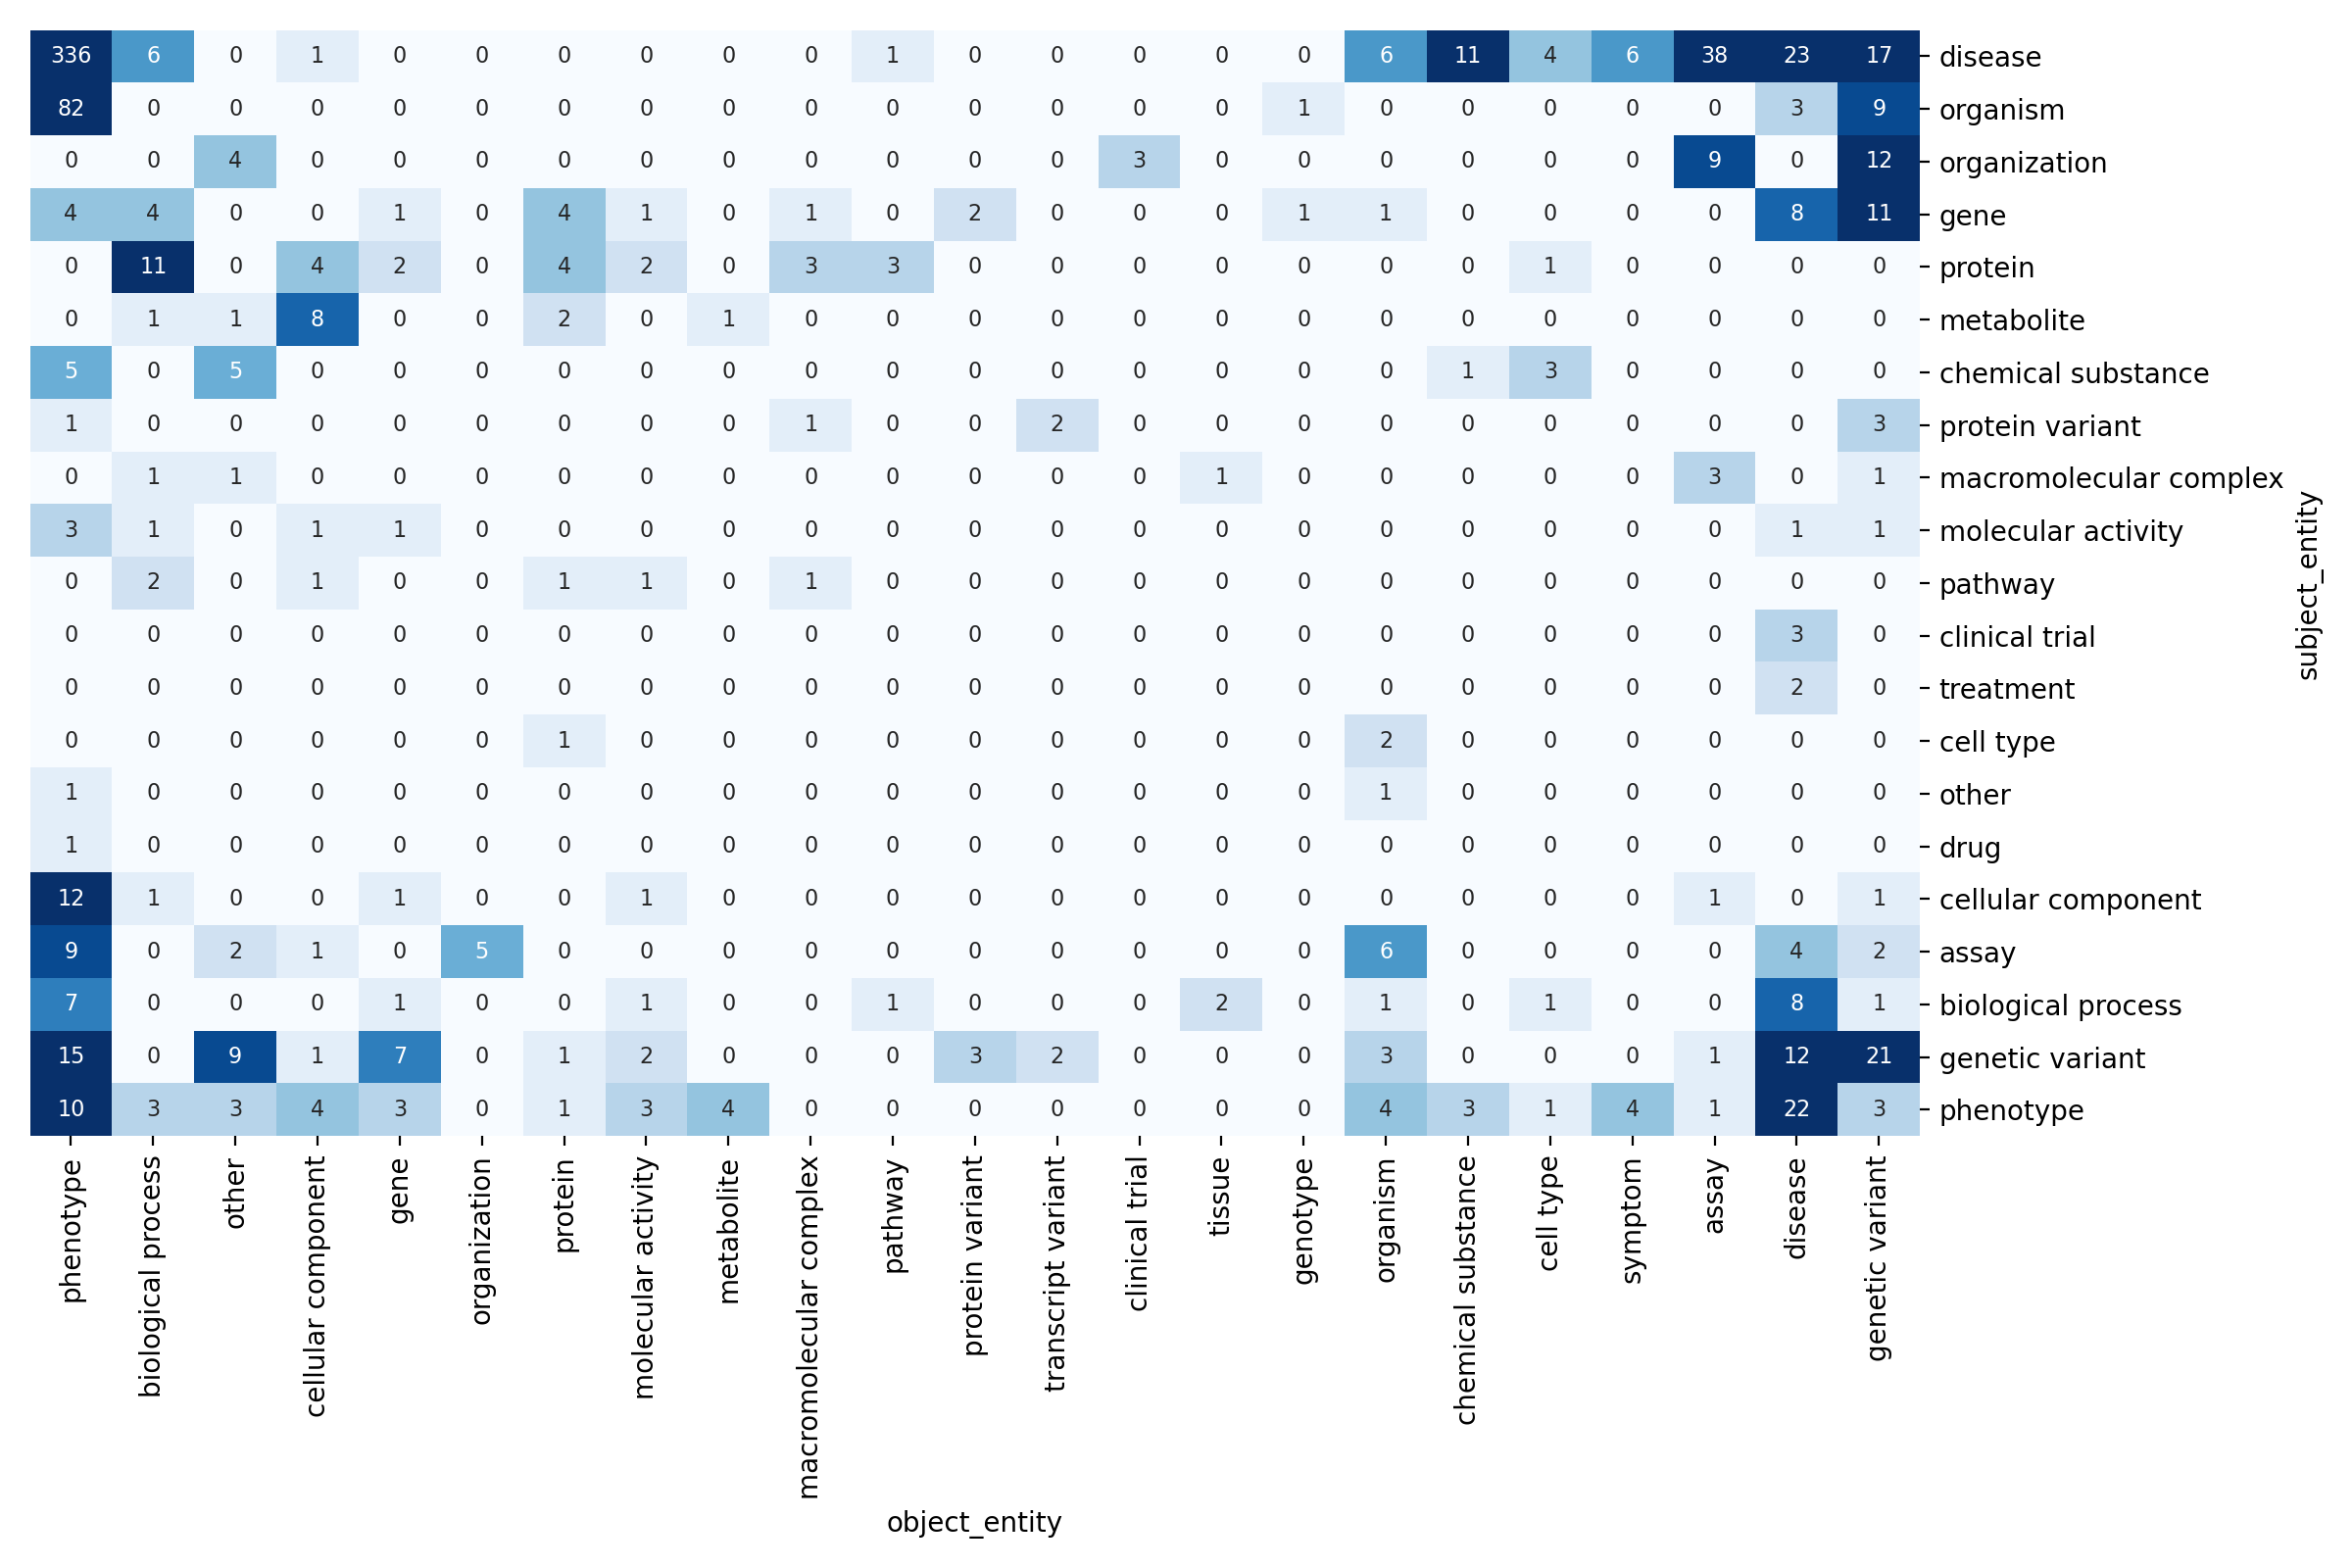

In [156]:
(
    relations
    .assign(subject_entity=lambda df: df["subject_entity"].str.replace("[<>]", "", regex=True))
    .assign(object_entity=lambda df: df["object_entity"].str.replace("[<>]", "", regex=True))
    [["subject_entity", "object_entity"]]
    .value_counts()
    .unstack()
    .pipe(lambda df: df.loc[
        df.sum(axis=1).sort_values(ascending=False).index,
        df.sum(axis=0).sort_values(ascending=False).index
    ])
    .pipe(utils.apply, lambda df: display(Markdown('### Subject/object co-occurrence frequency')))
    .pipe(lambda df: sns.clustermap(
        df.fillna(0).astype(int), cmap='Blues', figsize=(12, 8),
        xticklabels=1, yticklabels=1, annot=True, fmt='d', annot_kws={"size": 8},
        tree_kws={"linewidths": 0.}, vmin=0, vmax=10, cbar_pos=None,
        dendrogram_ratio=(0, 0)
    ))
);

Show patterns in predicate frequencies:

In [141]:
expected_predicates = [
    v
    for e in (
        prompt
        .split('Predicates to extract:')[1]
        .split('Here is the text to extract relations from:')[0]
        .split('\n-')
    )
    if (v := e.strip())
]
display(len(expected_predicates))
expected_predicates[:5]

59

['affects risk for', 'associated with', 'capable of', 'caused by', 'causes']

['has phenotype' 'associated with' 'has participant' 'causes' 'part of'
 'has genotype' 'caused by' 'located in' 'produces' 'correlated with'
 'has attribute' 'increases abundance of' 'decreases abundance of'
 'has output' 'location of' 'involved in' 'occurs in' 'performed'
 'used in' 'produced by' 'not associated with' 'has gene product'
 'contributes to' 'demonstrates' 'derives from' 'participates in' 'treats'
 'not correlated with' 'is marker for' 'enables' 'manifestation of'
 'negatively correlated with' 'confirms' 'cause' 'not seen in' 'has role'
 'is allele of' 'interacts with' 'catalyzes' 'degraded by'
 'translocated to' 'detected by' 'does not produce' 'also known as'
 'initiated' 'positively correlated with' 'processed through' 'is part of'
 'expresses' 'responsible for' 'includes' 'published' 'approved'
 'implicated in' 'confirmed by' 'disrupts' 'form' 'undergo' 'mediates'
 'postulated to play a role in' 'performed in' 'identified'
 'plays a role in' 'encoded by' 'identifies'

,predicate,count,type
0,has phenotype,329,expected
1,associated with,158,expected
2,has participant,61,expected
3,causes,55,expected
4,part of,33,expected
5,has genotype,32,expected
6,caused by,30,expected
7,located in,22,expected
8,produces,17,expected
9,correlated with,15,expected


### Predicate frequencies

**Note**: `unexpected` = not suggested in prompt, `expected` = exact match to predicate in prompt

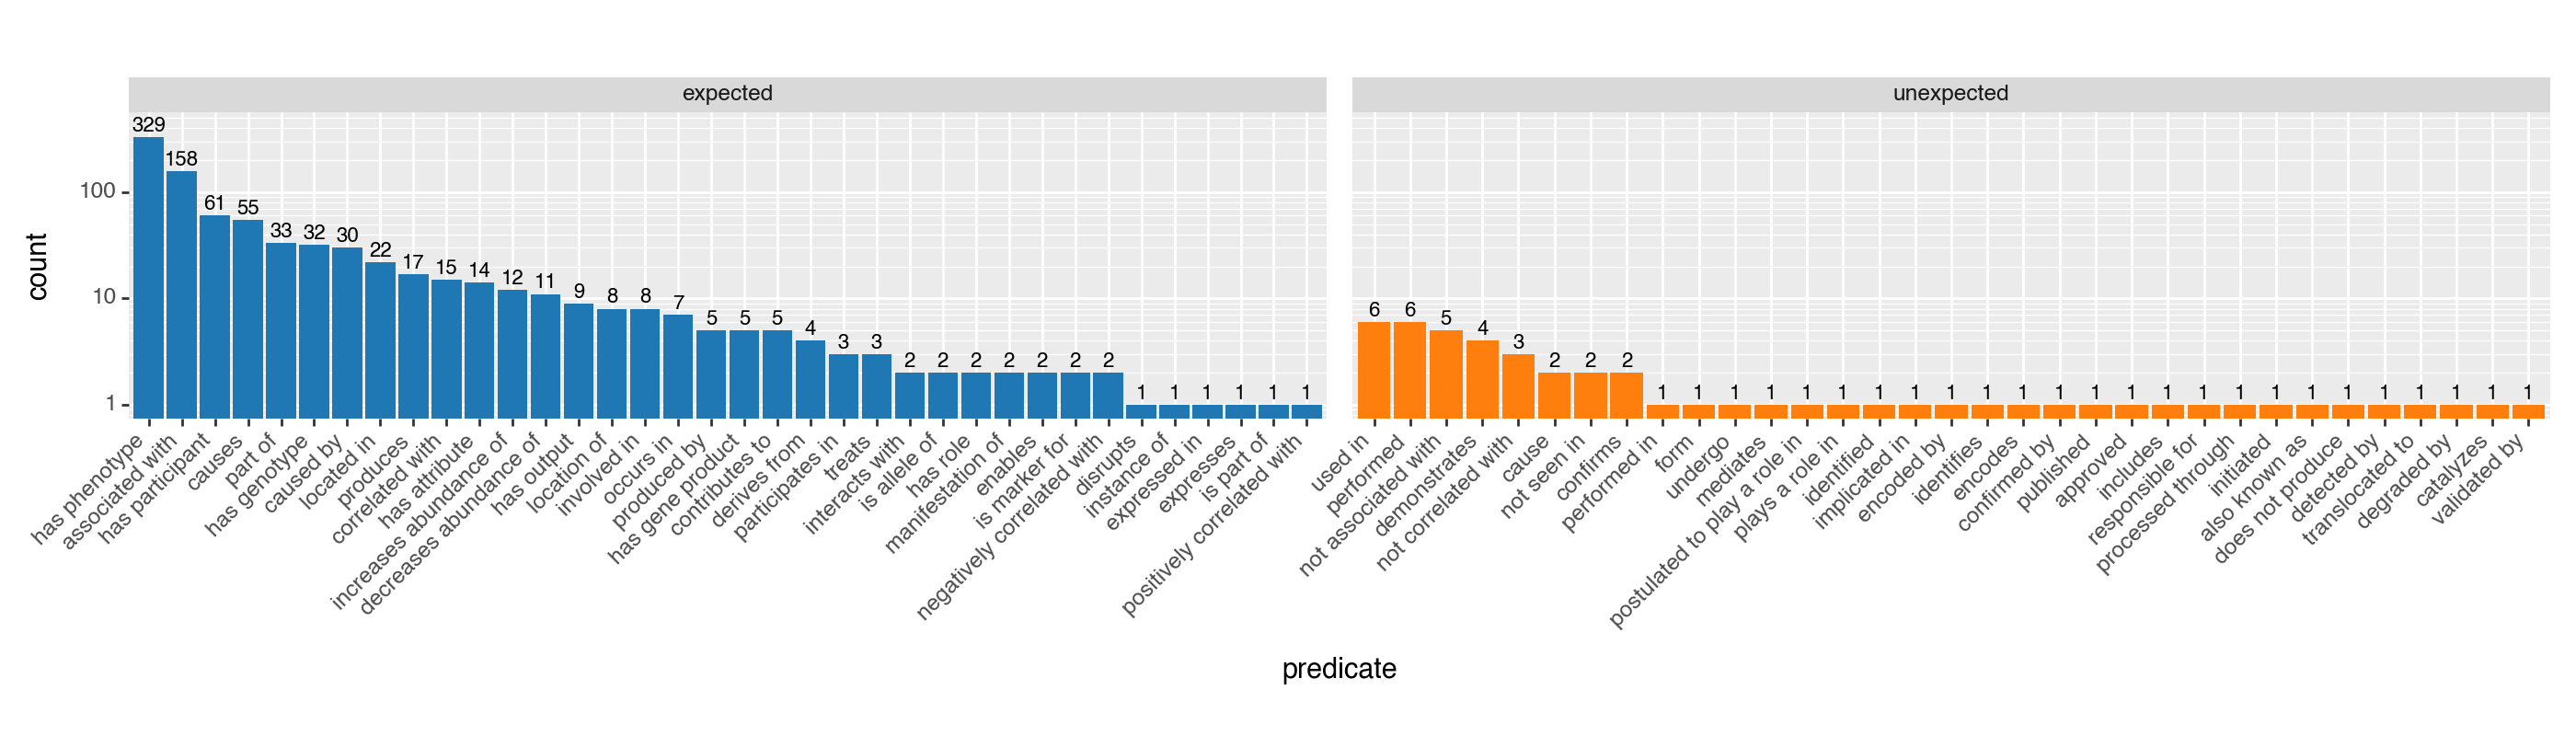

<Figure Size: (1400 x 400)>

In [157]:
predicate_counts = (
    relations.predicate.value_counts()
    .to_frame()
    .reset_index()
    .assign(type=lambda df: df['predicate'].isin(expected_predicates).map({True: 'expected', False: 'unexpected'}))
)
(
    predicate_counts
    .assign(predicate=lambda df: pd.Categorical(
        df['predicate'], ordered=True,
        categories=df.sort_values('count', ascending=False)['predicate']
    ))
    .pipe(utils.apply, lambda df: print(predicate_counts['predicate'].unique()))
    .pipe(utils.apply, lambda df: display(predicate_counts.head(25).style.background_gradient(cmap='Blues')))
    .pipe(utils.apply, lambda df: display(Markdown('### Predicate frequencies')))
    .pipe(utils.apply, lambda df: display(Markdown('**Note**: `unexpected` = not suggested in prompt, `expected` = exact match to predicate in prompt')))
    .pipe(utils.apply, lambda df: display(
        pn.ggplot(df, pn.aes(x='predicate', y='count', label='count', fill='type')) + 
        pn.facet_wrap('~ type', scales='free_x') +
        pn.geom_text(size=8, nudge_y=.1) + 
        pn.geom_col() + 
        pn.guides(fill=False) +
        pn.scale_fill_manual(values=['#1f77b4', '#ff7f0e']) +
        pn.scale_y_log10() +
        pn.theme(
            axis_text_x=pn.element_text(rotation=45, hjust=1),
            figure_size=(14, 4)
        )
    ))
);

Show relations with unexpected predicates:

In [144]:
(
    relations
    .merge(
        predicate_counts
        .pipe(lambda df: df[df['type'] != 'expected']),
        on='predicate'
    )
    .sort_values('predicate')
)

,subject,subject_entity,predicate,object,object_entity,doc_id,doc_filename,count,type
3,N-glycanase 1,protein,also known as,peptide:N-glycanase,protein,PMC4243708,PMC4243708.txt,1,unexpected
23,Stanford Institutional Review Board,organization,approved,this study,<other>,PMC4243708,PMC4243708.txt,1,unexpected
4,N-glycanase 1,protein,catalyzes,protein deglycosylation,biological process,PMC4243708,PMC4243708.txt,1,unexpected
0,Mutations,genetic variant,cause,Inherited Disorder of the Endoplasmic Reticulum-Associated Degradation,disease,PMC4243708,PMC4243708.txt,2,unexpected
1,Mutations in RNF170,genetic variant,cause,late- onset autosomal dominant sensory ataxia,disease,PMC4243708,PMC4243708.txt,2,unexpected
10,Sanger sequencing of NGLY1,assay,confirmed by,GeneDx,organization,PMC4243708,PMC4243708.txt,1,unexpected
26,CLIA-certified laboratory,organization,confirms,p.R401X,genetic variant,PMC4243708,PMC4243708.txt,2,unexpected
27,GeneDx,organization,confirms,p.R401X,genetic variant,PMC4243708,PMC4243708.txt,2,unexpected
7,Misfolded glycoproteins,protein,degraded by,cytosolic enzymes,protein,PMC4243708,PMC4243708.txt,1,unexpected
52,neurophysiological testing,assay,demonstrates,motor neuron degeneration,phenotype,PMC7477955,PMC7477955.txt,4,unexpected


A number of these are quite useful and suggest import improvements that could be made to the information extracted:

- Transferrin isoelectric focusing -> *used in* -> NGLY1-deficient patients
- Misfolded glycoproteins -> *degraded by* -> cytosolic enzymes
- RNF170 (an E3-ubiquitin ligase) -> `mediates` -> ubiquitination and processing of the IP3 receptor
- NGLY1 deficiency -> `not` *associated with* -> ocular apraxia
    - > [From PMC7477955] In addition, we could not confirm abnormal storage material in the three liver biopsy specimens we analyzed, nor did we observe ocular apraxia in our individuals, despite performing detailed ophthalmologic evaluations that involved some subjects previously reported to have ocular apraxia.
- NGLY1 deficiency -> `not` *associated with* -> lipodystrophy
    - > [From PMC4243708] Unlike CDGs, NGLY1 deficiency does not appear to be associated with cerebellar atrophy, lipodystrophy, or significant heart manifestations
- Misfolded glycoproteins -> *translocated to* -> cytosol
- Misfolded glycoproteins -> *processed through* -> endoplasmic reticulum associated degradation pathway
- Abnormal E3-ubiquitin ligase activity -> `postulated` *to play a role in* -> Charcot-Marie-Tooth disease

### Phenotype frequencies

Visualize frequencies of phenotypes associated with NGLY1 deficiency:

In [161]:
relations

,subject,subject_entity,predicate,object,object_entity,doc_id,doc_filename
0,Mutations,genetic variant,cause,Inherited Disorder of the Endoplasmic Reticulum-Associated Degradation,disease,PMC4243708,PMC4243708.txt
1,NGLY1,gene,has gene product,Mutations,genetic variant,PMC4243708,PMC4243708.txt
2,ERAD pathway,pathway,responsible for,translocation of misfolded proteins,biological process,PMC4243708,PMC4243708.txt
3,ERAD pathway,pathway,has participant,proteasome,molecular activity,PMC4243708,PMC4243708.txt
4,N-glycanase 1,protein,involved in,ERAD pathway,pathway,PMC4243708,PMC4243708.txt
...,...,...,...,...,...,...,...
916,NGLY1 deficiency,disease,causes,conjunctival injection,symptom,PMC7477955,PMC7477955.txt
917,NGLY1 deficiency,disease,causes,limbal neovascularization,symptom,PMC7477955,PMC7477955.txt
918,NGLY1 deficiency,disease,causes,corneal scarring,symptom,PMC7477955,PMC7477955.txt
919,NGLY1 deficiency,disease,causes,severe dry eyes,symptom,PMC7477955,PMC7477955.txt


In [243]:
def normalize(term):
    term = term.strip()
    if term == 'NGLY1-CDDG':
        return utils.NGLY1_DEFICIENCY
    return term

phenotypes = (
    relations
    .assign(subject=lambda df: df['subject'].apply(normalize))
    .assign(object=lambda df: df['object'].apply(normalize))
    .pipe(lambda df: df[
        (df['subject'] == utils.NGLY1_DEFICIENCY) | 
        (df['object'] == utils.NGLY1_DEFICIENCY)
    ])
    .pipe(lambda df: pd.DataFrame([
        (r['object'], r['object_entity'], r['predicate'])
        if r['subject'] == utils.NGLY1_DEFICIENCY else 
        (r['subject'], r['subject_entity'], r['predicate'])
        for _, r in df.iterrows()
    ], columns=['entity', 'entity_type', 'relation']))
    .pipe(lambda df: df[
        df['entity_type'].str.contains('phenotype|disease|symptom', regex=True) 
    ])
    .pipe(utils.apply, lambda df: display(df['entity_type'].value_counts().head(15)))
    .pipe(utils.apply, lambda df: display(df['relation'].value_counts().head(15)))
    .pipe(utils.apply, lambda df: display(df['entity'].value_counts().head(15)))
    .groupby('entity')
    .agg(
        count=('relation', 'count'), 
        relations=('relation', 'unique'),
        types=('entity_type', 'unique')
    )
    .reset_index()
    .pipe(utils.apply, lambda df: display(
        df.sort_values('count', ascending=False).head(50)
    ))
    .sort_values('entity')
    .reset_index(drop=True)
    .assign(id=lambda df: df.index + 1)
)
phenotypes.head(5)

entity_type
phenotype    349
disease       23
symptom        6
Name: count, dtype: int64

relation
has phenotype          242
associated with         89
causes                  24
caused by               13
not associated with      5
part of                  2
instance of              1
is marker for            1
manifestation of         1
Name: count, dtype: int64

entity
hypotonia                       7
global developmental delay      6
peripheral neuropathy           6
movement disorder               5
elevated liver transaminases    4
diminished reflexes             4
seizures                        4
hypolacrima                     4
acquired microcephaly           4
liver disease                   4
delayed bone age                4
developmental delay             3
scoliosis                       3
microcephaly                    3
EEG abnormalities               3
Name: count, dtype: int64

,entity,count,relations,types
163,hypotonia,7,"[causes, has phenotype, associated with]",[phenotype]
230,peripheral neuropathy,6,"[has phenotype, associated with, causes]","[phenotype, disease]"
140,global developmental delay,6,"[causes, has phenotype, caused by, associated with]",[phenotype]
207,movement disorder,5,"[causes, has phenotype, associated with]",[phenotype]
161,hypolacrima,4,"[has phenotype, associated with, causes]",[phenotype]
258,seizures,4,"[associated with, has phenotype]",[phenotype]
179,liver disease,4,"[associated with, has phenotype]","[disease, phenotype]"
116,diminished reflexes,4,"[associated with, has phenotype, caused by]",[phenotype]
58,acquired microcephaly,4,"[has phenotype, associated with]","[phenotype, disease]"
110,delayed bone age,4,"[has phenotype, associated with]",[phenotype]


,entity,count,relations,types,id
0,Alacrima/hypolacrima,1,[has phenotype],[phenotype],1
1,Anal stenosis,1,[has phenotype],[phenotype],2
2,CDGs,1,[not associated with],[disease],3
3,Cerebral atrophy,1,[manifestation of],[phenotype],4
4,Chalazions,1,[has phenotype],[phenotype],5


In [249]:
taxonomy_json_string = llm.chat_completion(
    "phenotype_taxonomy_1.txt",
    disease=utils.NGLY1_DEFICIENCY, 
    phenotypes="\n".join([f"{r.id}. {r.entity}" for r in phenotypes.itertuples()])
)
taxonomy_json_string

INFO:ngly1_gpt.llm:Prompt (temperature=None, model=gpt-4):
Define a taxonomy to describe the following list of human phenotypes associated with NGLY1 deficiency:

--- BEGIN PHENOTYPE LIST ---
1. Alacrima/hypolacrima
2. Anal stenosis
3. CDGs
4. Cerebral atrophy
5. Chalazions
6. Communication scores
7. Constipation
8. Corneal ulcerations/scarring
9. Daily Living Skills scores
10. Developmental delays in mastication
11. Dysmorphic features
12. Dystonic movements of the tongue
13. EEG abnormalities
14. Elevated AFP
15. Elevated liver transaminases
16. Gastric pH alteration
17. Generalized weakness of the lips and tongue
18. Global developmental delay
19. Hypotonia
20. IUGR
21. Lactic acidemia
22. Lactic acidosis
23. Lagophthalmous
24. Liver fibrosis
25. Liver storage or vacuolization
26. Microcephaly
27. Motor deficits
28. Movement disorder
29. Neonatal jaundice
30. Nijmegen Scores
31. Ocular apraxia
32. Oral motor deficits
33. Peripheral neuropathy
34. Premature spillage
35. QTcB >440 ms


'{\n    "id": 1,\n    "name": "NGLY1 deficiency Phenotypes",\n    "description": "A collection of phenotypic characteristics associated with NGLY1 deficiency.",\n    "descendants": [\n        {\n            "id": 2,\n            "name": "Physical Features",\n            "description": "Phenotypes related to physical aspects of the body.",\n            "descendants":[\n                {\n                    "id": 3,\n                    "name": "Skeletal Issues",\n                    "description": "Phenotypes involving the skeletal system, including bones and joints.",\n                    "descendants": []\n                },\n                {\n                    "id": 4,\n                    "name": "Growth Issues",\n                    "description": "Phenotypes related to growth delays or abnormalities, including body size, weight, or developmental stages.",\n                    "descendants": []\n                },\n                {\n                    "id": 5,\n              

In [252]:
taxonomy = json.loads(taxonomy_json_string)
taxonomy

{'id': 1,
 'name': 'NGLY1 deficiency Phenotypes',
 'description': 'A collection of phenotypic characteristics associated with NGLY1 deficiency.',
 'descendants': [{'id': 2,
   'name': 'Physical Features',
   'description': 'Phenotypes related to physical aspects of the body.',
   'descendants': [{'id': 3,
     'name': 'Skeletal Issues',
     'description': 'Phenotypes involving the skeletal system, including bones and joints.',
     'descendants': []},
    {'id': 4,
     'name': 'Growth Issues',
     'description': 'Phenotypes related to growth delays or abnormalities, including body size, weight, or developmental stages.',
     'descendants': []},
    {'id': 5,
     'name': 'Facial Features',
     'description': 'Phenotypes specifically related to the facial structure or appearance.',
     'descendants': []}]},
  {'id': 6,
   'name': 'Neurological Issues',
   'description': 'Phenotypes related to the nervous system, including brain function and motor control.',
   'descendants': [{'id

In [250]:
taxonomy_mapping_csv = llm.chat_completion(
    "phenotype_taxonomy_2.txt",
    disease=utils.NGLY1_DEFICIENCY, 
    phenotypes="\n".join([f"{r.id}. {r.entity}" for r in phenotypes.itertuples()]),
    taxonomy=taxonomy_json_string
)
taxonomy_mapping_csv

INFO:ngly1_gpt.llm:Prompt (temperature=None, model=gpt-4):
The following taxonomy describes human phenotypes associated with NGLY1 deficiency:

--- BEGIN TAXONOMY JSON ---
{
    "id": 1,
    "name": "NGLY1 deficiency Phenotypes",
    "description": "A collection of phenotypic characteristics associated with NGLY1 deficiency.",
    "descendants": [
        {
            "id": 2,
            "name": "Physical Features",
            "description": "Phenotypes related to physical aspects of the body.",
            "descendants":[
                {
                    "id": 3,
                    "name": "Skeletal Issues",
                    "description": "Phenotypes involving the skeletal system, including bones and joints.",
                    "descendants": []
                },
                {
                    "id": 4,
                    "name": "Growth Issues",
                    "description": "Phenotypes related to growth delays or abnormalities, including body size, weight

'phenotype_id|taxonomy_term_id\n1|15\n2|14\n3|15\n4|8\n5|5\n6|8\n7|14\n8|13\n9|8\n10|14\n11|5\n12|7\n13|9\n14|10\n15|12\n16|14\n17|5\n18|8\n19|7\n20|4\n21|10\n22|10\n23|13\n24|12\n25|12\n26|3\n27|7\n28|7\n29|12\n30|8\n31|13\n32|7\n33|6\n34|14\n35|16\n36|3\n37|9\n38|3\n39|13\n40|8\n41|7\n42|11\n43|15\n44|15\n45|8\n46|6\n47|13\n48|8\n49|15\n50|15\n51|15\n52|3\n53|13\n54|12\n55|12\n56|12\n57|12\n58|12\n59|3\n60|7\n61|16\n62|12\n63|10\n64|13\n65|10\n66|7\n67|7\n68|7\n69|3\n70|6\n71|6\n72|6\n73|8\n74|8\n75|13\n76|3\n77|16\n78|8\n79|8\n80|16\n81|6\n82|16\n83|8\n84|15\n85|7\n86|7\n87|13\n88|14\n89|7\n90|9\n91|16\n92|7\n93|13\n94|15\n95|15\n96|13\n97|7\n98|14\n99|3\n100|13\n101|13\n102|13\n103|13\n104|13\n105|3\n106|16\n107|16\n108|15\n109|16\n110|13\n111|3\n112|8\n113|8\n114|8\n115|8\n116|3\n117|6\n118|3\n119|14\n120|3\n121|13\n122|7\n123|5\n124|6\n125|7\n126|12\n127|12\n128|12\n129|12\n130|12\n131|12\n132|13\n133|13\n134|3\n135|7\n136|4\n137|7\n138|16\n139|9\n140|14\n141|8\n142|8\n143|3\n144

In [251]:
len(taxonomy_mapping_csv.split("\n"))

291

In [236]:
from typing import Any
import networkx as nx

def convert_taxonomy(taxonomy: Any, term_mapping: dict[int, list[int]]) -> nx.DiGraph:
    def add_node(graph, node, parent=None):
        node_id = node['id']
        graph.add_node(node['name'], **{k: v for k, v in node.items() if k != 'descendants'})
        if parent is not None:
            graph.add_edge(parent, node['name'])
        
        if node_id in term_mapping:
            for term in node['terms']:
                term_name = term_names.get(term, f"{node['name']}_term_{term}")
                graph.add_node(term_name)
                graph.add_edge(node['name'], term_name)
                
        if 'descendants' in node:
            for child in node['descendants']:
                add_node(graph, child, node['name'])

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    add_node(G, taxonomy)
    return G

taxonomy_graph = convert_taxonomy(taxonomy, phenotypes.set_index('id')['entity'].to_dict())
taxonomy_graph

In [239]:
(
    phenotypes
    .assign(taxonomy_nodes=lambda df: df['id'].map(
        pd.DataFrame([
            dict(id=term_id, node=n)
            for n in taxonomy_graph.nodes
            for term_id in taxonomy_graph.nodes[n].get('term_ids', [])
        ])
        .groupby('id')['node'].unique()
    ))
)

,entity,count,relations,types,id,taxonomy_nodes
0,Alacrima/hypolacrima,1,[has phenotype],[phenotype],1,[Eye conditions/disorders]
1,Anal stenosis,1,[has phenotype],[phenotype],2,[Abdominal disorders]
2,CDGs,1,[not associated with],[disease],3,[Glycosylation disorders]
3,Cerebral atrophy,1,[manifestation of],[phenotype],4,[Brain disorders]
4,Chalazions,1,[has phenotype],[phenotype],5,[Eye conditions/disorders]
5,Communication scores,1,[has phenotype],[phenotype],6,[Clinical Scores]
6,Constipation,1,[has phenotype],[phenotype],7,[Abdominal disorders]
7,Corneal ulcerations/scarring,1,[has phenotype],[phenotype],8,[Eye conditions/disorders]
8,Daily Living Skills scores,1,[has phenotype],[phenotype],9,[Clinical Scores]
9,Developmental delays in mastication,1,[has phenotype],[phenotype],10,[Development disorders]


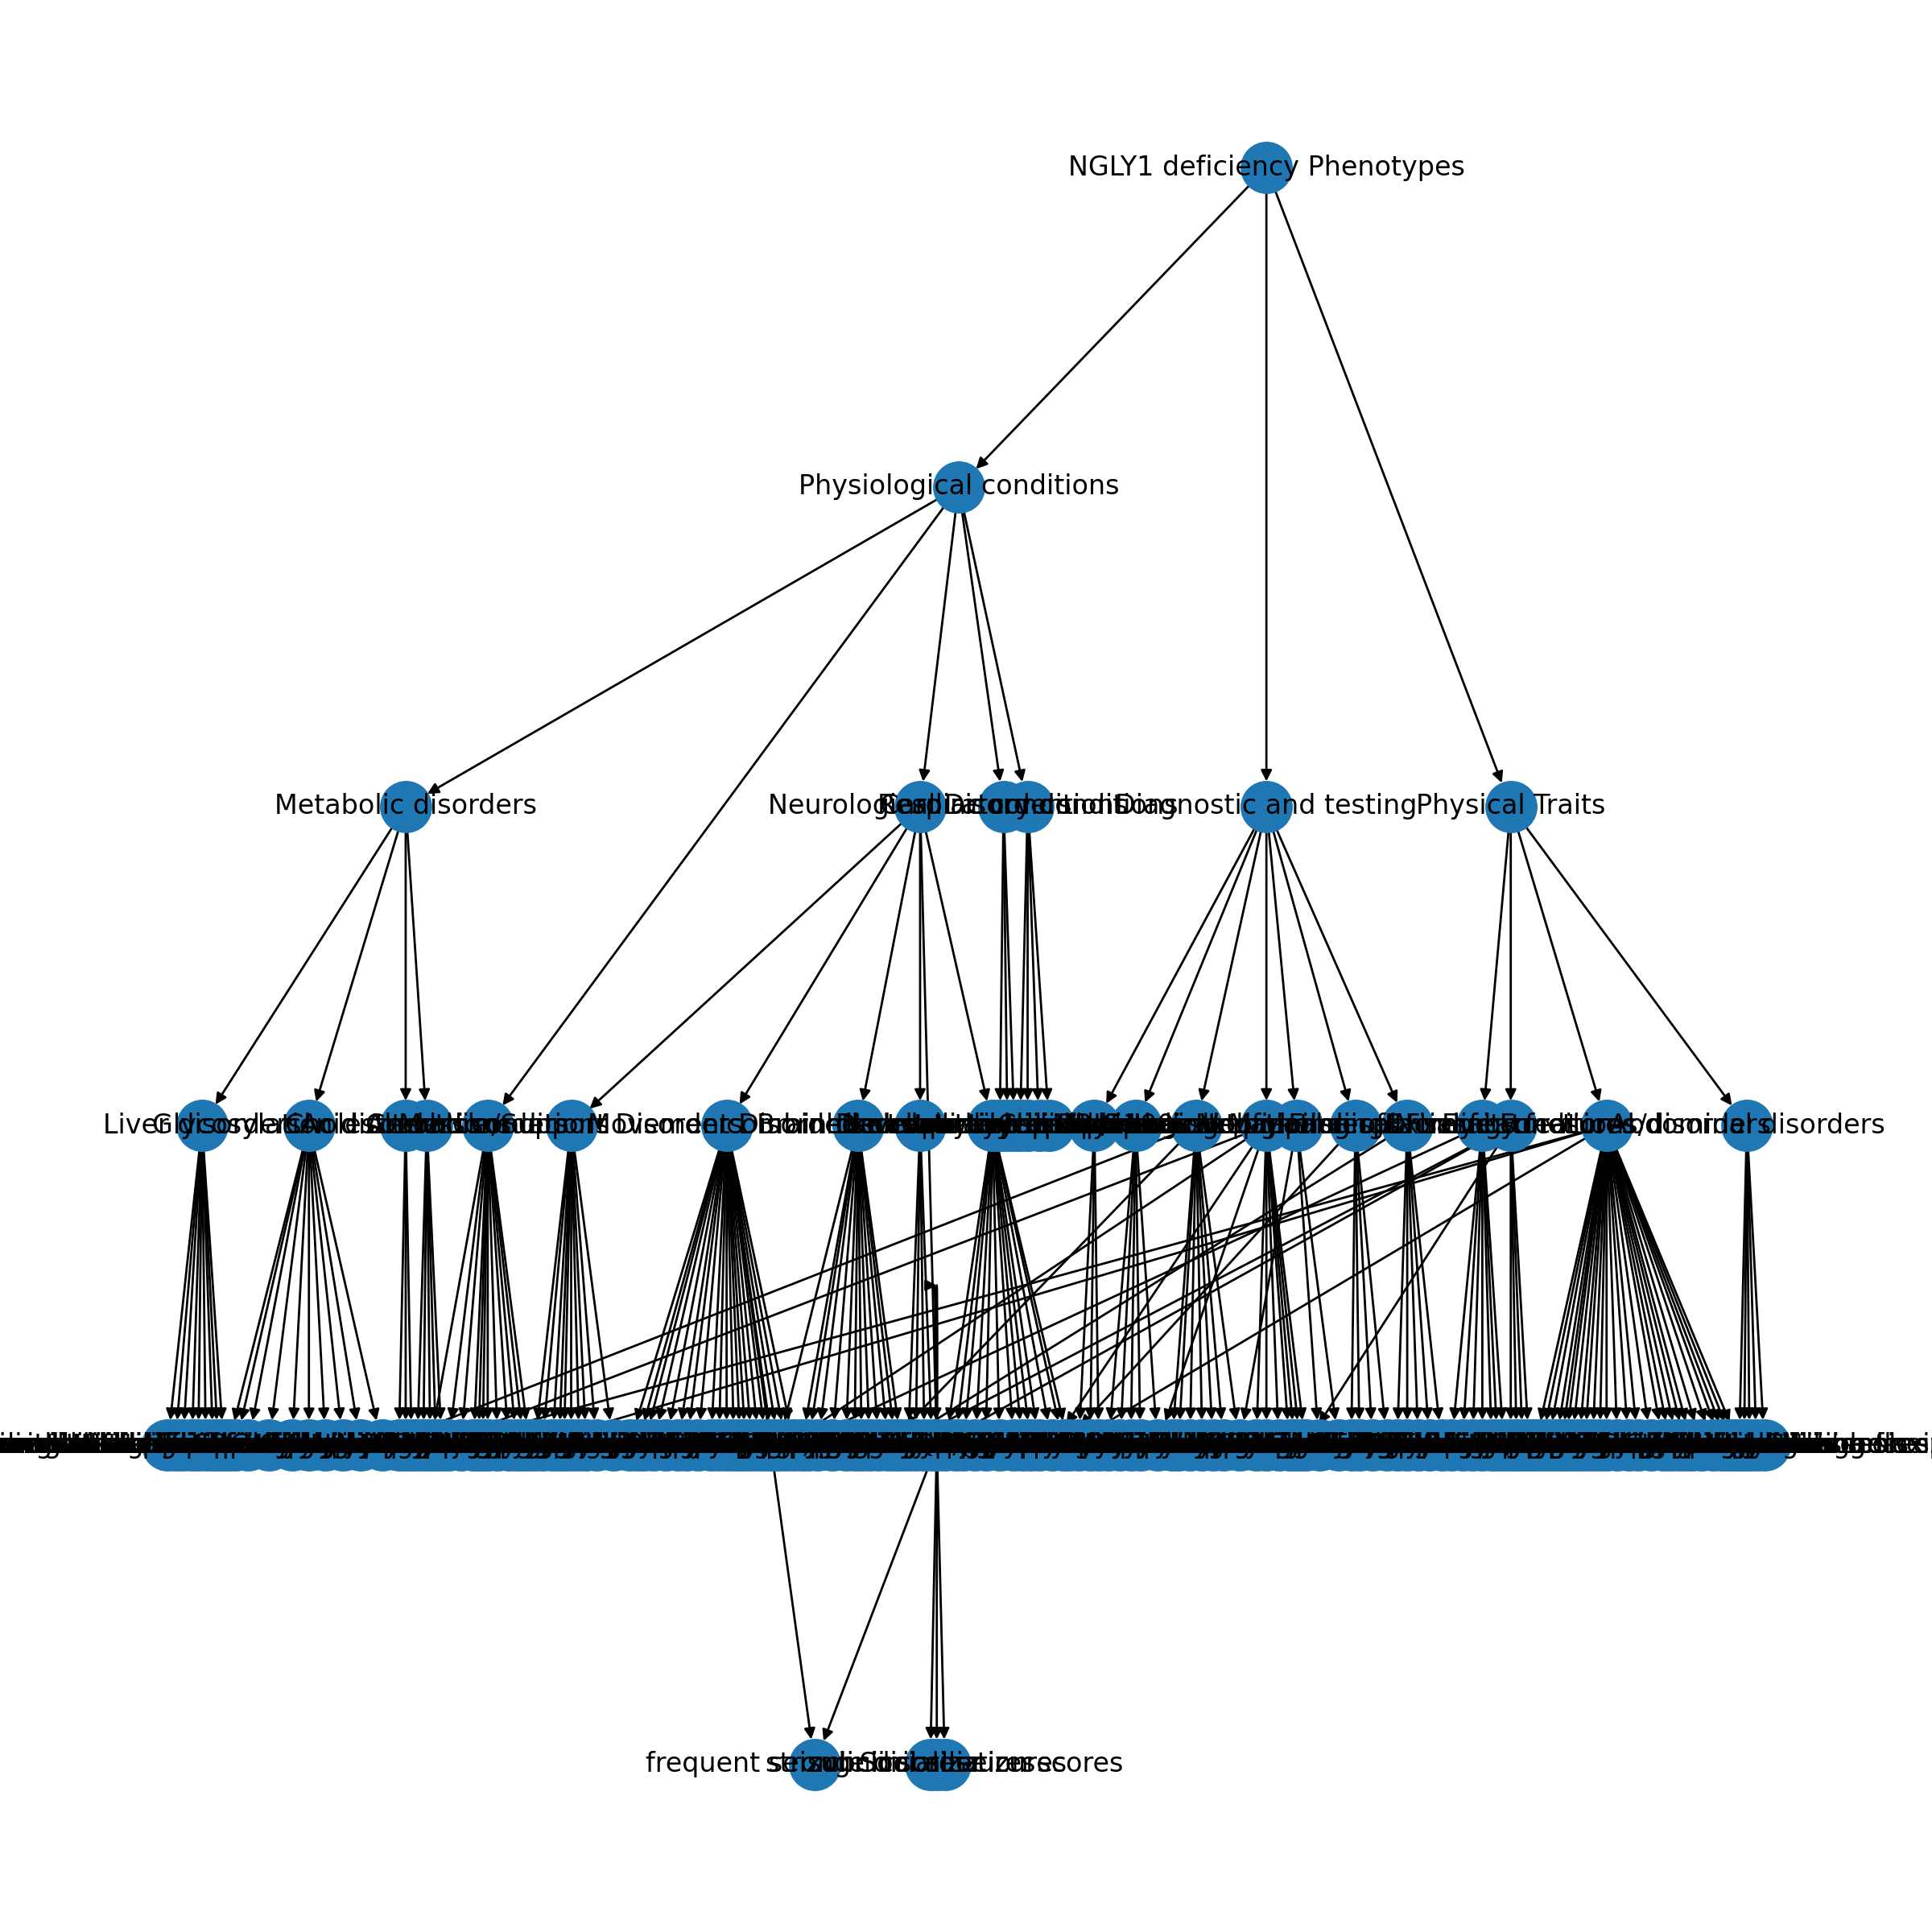

In [230]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

plt.figure(figsize=(12,12))  
pos = graphviz_layout(taxonomy_graph, prog="dot")
nx.draw(taxonomy_graph, pos, node_size=500, with_labels=True)
plt.show()


In [189]:
print("\n".join([f"- {e}" for e in sorted(phenotypes['entity'].unique())]))

- Alacrima/hypolacrima
- Anal stenosis
- CDGs
- Cerebral atrophy
- Chalazions
- Communication scores
- Constipation
- Corneal ulcerations/scarring
- Daily Living Skills scores
- Developmental delays in mastication
- Dysmorphic features
- Dystonic movements of the tongue
- EEG abnormalities
- Elevated AFP
- Elevated liver transaminases
- Gastric pH alteration
- Generalized weakness of the lips and tongue
- Global developmental delay
- Hypotonia
- IUGR
- Lactic acidemia
- Lactic acidosis
- Lagophthalmous
- Liver fibrosis
- Liver storage or vacuolization
- Microcephaly
- Motor deficits
- Movement disorder
- Neonatal jaundice
- Nijmegen Scores
- Ocular apraxia
- Oral motor deficits
- Peripheral neuropathy
- Premature spillage
- QTcB >440 ms
- Scoliosis
- Seizures
- Small hands/feet
- Strabismus
- Vineland Adaptive Behavior Composite scores
- a movement disorder
- abnormal abdominal ultrasound
- abnormal accumulation of misfolded glycoproteins
- abnormal biochemical markers in mitochondropa

##### Genetics

In [157]:
(
    relations
    .pipe(lambda df: df[
        df['subject_entity'].str.contains('variant|') | 
        df['object_entity'].str.contains('variant')
    ])
)

,subject,subject_entity,predicate,object,object_entity,doc_id,doc_filename
0,Mutations,genetic variant,cause,Inherited Disorder of the Endoplasmic Reticulum-Associated Degradation,disease,PMC4243708,PMC4243708.txt
1,NGLY1,gene,has gene product,Mutations,genetic variant,PMC4243708,PMC4243708.txt
14,c.1201A>T (p.R401X),genetic variant,is allele of,NGLY1 deficiency,disease,PMC4243708,PMC4243708.txt
18,c.1201A>T (p.R401X),genetic variant,associated with,severe disease,disease,PMC4243708,PMC4243708.txt
33,NGLY1 deficiency,disease,caused by,mutations in NGLY1,genetic variant,PMC4243708,PMC4243708.txt
43,mutations in NGLY1,genetic variant,causes,NGLY1 deficiency,disease,PMC4243708,PMC4243708.txt
44,mutations in NGLY1,genetic variant,causes,impaired cytosolic degradation,molecular activity,PMC4243708,PMC4243708.txt
45,mutations in NGLY1,genetic variant,causes,abnormal accumulation of misfolded glycoproteins,phenotype,PMC4243708,PMC4243708.txt
46,mutations in NGLY1,genetic variant,causes,accumulation of an amorphous unidentified substance,phenotype,PMC4243708,PMC4243708.txt
47,mutations in NGLY1,genetic variant,causes,congenital disorder of glycosylation,phenotype,PMC4243708,PMC4243708.txt
